<a href="https://colab.research.google.com/github/LuccaRomagnolli/Neural-Networks/blob/main/Reducing_Overfitting_in_Deep_Learning_models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reducing Overfitting in Conv Networks

### Estimated completion time: 30 minutes

In this notebook we´ll explore some techniques to reduce overfitting in a deep leearning models

We will follow these steps:

1. Explore how data augmentation works by making
2. random transformations to training images.
3. Add data augmentation to our data preprocessing.
4. Add dropout to the convnet.
5. Retrain the model and evaluate loss and accuracy.


In [ ]:
# Get the data
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip


--2025-04-24 22:53:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   119MB/s    in 0.6s    

2025-04-24 22:53:37 (119 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Prepare our dataset *with* dog-vs-cat google files

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

## 1 - Exploring data Augmentation
 This can be done by configuring a number of random trasnformations to be perfomed on **the** images read by our`ImageDataGenerator` instance. Let´s get started with an example

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)


  * `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
  * `width_shift` and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
  * `shear_rang` e is for randomly applying shearing transformations.
  * `zoom_range` is for randomly zooming inside pictures.
  * `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
  * `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


Next, let's apply the `datagen` transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

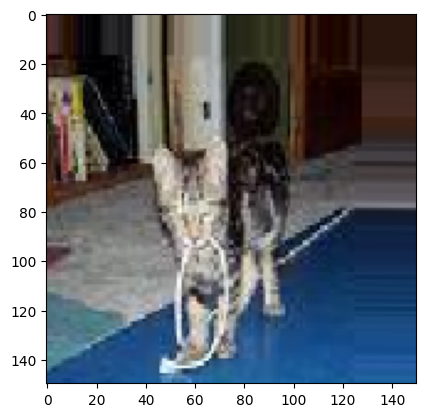

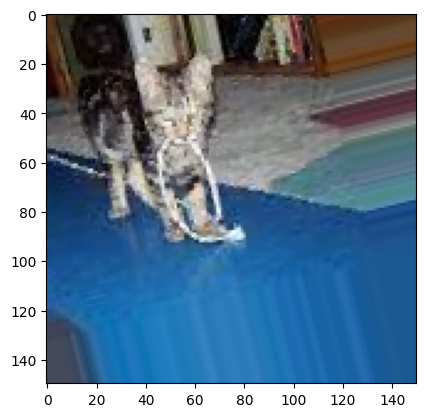

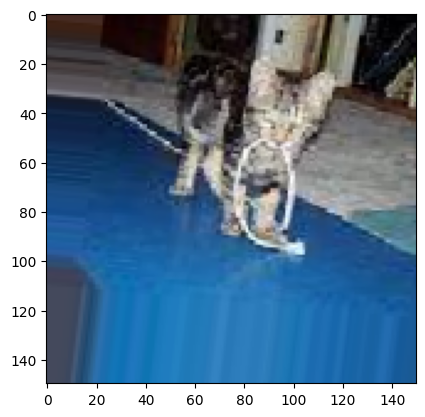

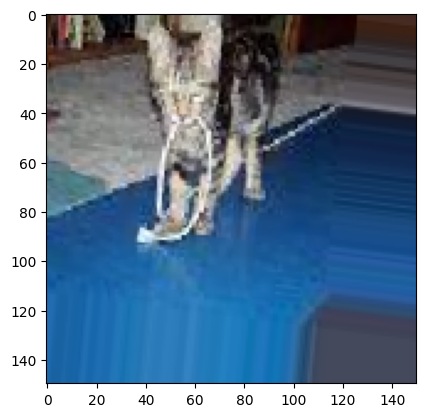

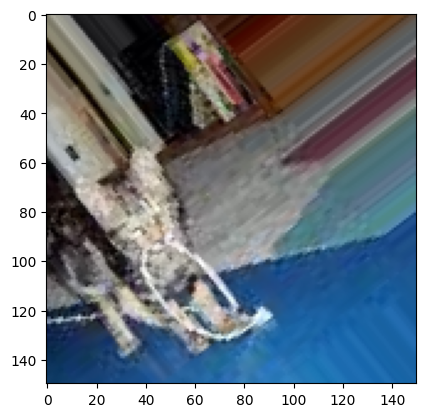

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

## Add Data Augmentation to the Preprocessing Step

Now let´s add our data-augmentation tranformations from `Exploring Data Augmentation` to our data preprossing configuration:

In [ ]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 2 - Adding Dropout layers

`Dropout`: While training, if you remove a random number of neurons and ignore them, their contribution to the neurons in the next layer is temporarily blocked This reduces the chances of the neurons becoming overspecialized. The network will still learn the same number of parameters, but it should be better at generalization that is, it should be more resilient to different inputs


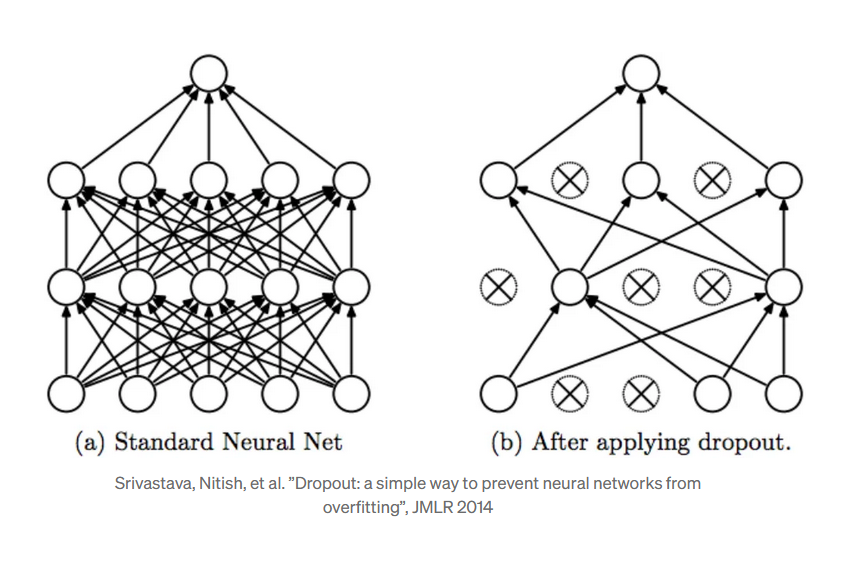

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop


# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

## Train the Model

With data augmentation and dropout in place, let's retrain our convnet model. This time, let's train on all 2,000 images available, for 30 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.) See if you can write the code yourself:

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 - 20s - 198ms/step - acc: 0.5285 - loss: 0.7065 - val_acc: 0.5960 - val_loss: 0.6681
Epoch 2/30
100/100 - 14s - 138ms/step - acc: 0.5905 - loss: 0.6687 - val_acc: 0.6170 - val_loss: 0.6346
Epoch 3/30
100/100 - 14s - 137ms/step - acc: 0.6355 - loss: 0.6402 - val_acc: 0.6490 - val_loss: 0.6116
Epoch 4/30
100/100 - 20s - 205ms/step - acc: 0.6390 - loss: 0.6395 - val_acc: 0.6400 - val_loss: 0.6232
Epoch 5/30
100/100 - 14s - 136ms/step - acc: 0.6450 - loss: 0.6220 - val_acc: 0.6950 - val_loss: 0.5875
Epoch 6/30
100/100 - 14s - 141ms/step - acc: 0.6775 - loss: 0.6012 - val_acc: 0.6940 - val_loss: 0.5695
Epoch 7/30
100/100 - 15s - 150ms/step - acc: 0.6770 - loss: 0.6076 - val_acc: 0.6590 - val_loss: 0.5843
Epoch 8/30
100/100 - 15s - 149ms/step - acc: 0.6820 - loss: 0.5898 - val_acc: 0.7020 - val_loss: 0.5629
Epoch 9/30
100/100 - 14s - 137ms/step - acc: 0.6975 - loss: 0.5910 - val_acc: 0.6870 - val_loss: 0.5890
Epoch 10/30
100/100 - 14s - 138ms/step - acc: 0.7030 - loss: 0.5

## Evaluate the Results

Let´s evaluate the results of model traning with data augmentation and dropout

Text(0.5, 1.0, 'Training and validation loss')

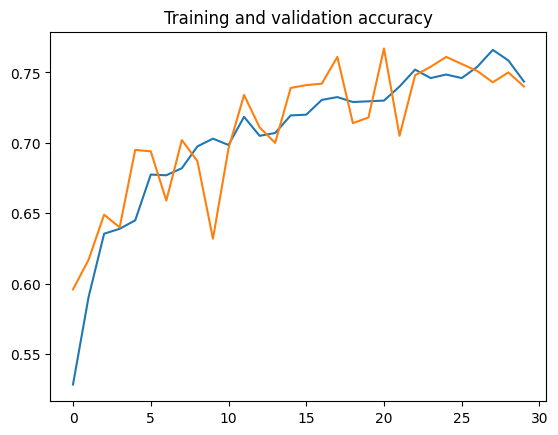

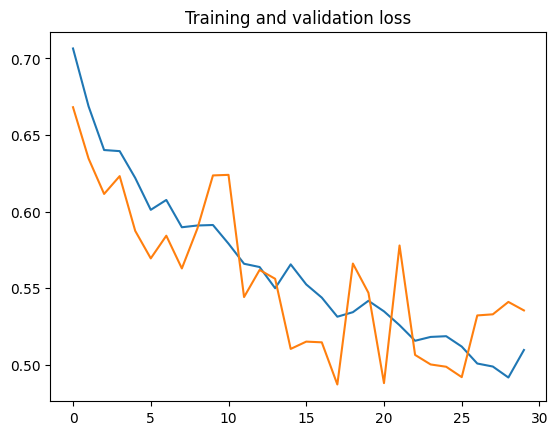

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')